## Import librarys

In [1]:
import numpy  as np
import pandas as pd
import pyprind
import random
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## Load word2vect

Se hace uso del modelo pre-entranado de Google: word2vect (obtenido de https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit).
Debido a que el volcabulario es muy grande, fueron seleccionadas las palabras que aparecen en nuestros datos de entrenamiento (lista de comentarios sobre películas). El resultado de la selección de palabras fue almacenado en 'words.npy'.

In [2]:
words = np.load('words.npy').item()
Wvals = np.array([words[p] for p in words])

## Import Data

In [3]:
stop = stopwords.words('english')
porter = PorterStemmer()

def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label   
            
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return text

def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return docs, y

## Preprocessing

In [4]:
def preprocessing(text):
    import re
    REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\n)")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_NO_SPACE.sub('', text.lower())
    text = REPLACE_WITH_SPACE.sub(' ', text)
    return text

## Data Analysis

In [5]:
doc_stream = stream_docs(path='shuffled_movie_data.csv')
x_, y_ = get_minibatch(doc_stream, size=50000)
count_words = [len(preprocessing(w).split())  for w in x_]

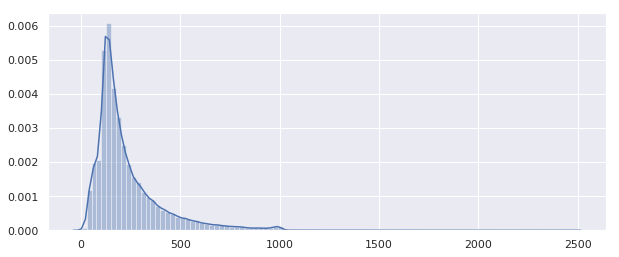

In [18]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,4)})
sns.distplot(count_words,bins=100)

In [19]:
threshold_words = np.percentile(count_words,80)
print("Maxima cantidad de palabras consideras en la red:", threshold_words)

Maxima cantidad de palabras consideras en la red: 318.0


## Features extraction

In [20]:
def featuresExtraction(text):
    review = list()
    count = 0
    
    for w in text.split():
        if w in words:
            review.append( words[w] )
            count += 1
        if not count<threshold_words:
            break
            
    while count<threshold_words:
        review.append( np.zeros(300) )
        count += 1
    
    # Get feature
    review = np.array(review).T
    
    return review.flatten() 

## Neural network

### No-Lineal functions

In [21]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
def sigmoid_deriv(z):
    return np.multiply( sigmoid(z), 1 - sigmoid(z) )
def tanh(z):
    return np.tanh(z)
def tanh_deriv(z):
    tanhz = tanh(z)
    return 1 - tanhz*tanhz
def ReLU(z):
    return np.multiply( (z>=0), z )
def ReLU_deriv(z):
    return (z>=0)
def SELU(z):
    neg = np.multiply( (z< 0), 1.758094*( np.exp(z) - 1 ) )
    pos = np.multiply( (z>=0), 1.0507  *         z        )
    return neg + pos
def SELU_deriv(z):
    return np.multiply( (z<0), 1.758094*np.exp(z) ) + 1.0507*(z>=0)
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))
def funDeriv(fun):
    if fun == sigmoid: return sigmoid_deriv;
    if fun ==    tanh: return    tanh_deriv;
    if fun ==    ReLU: return    ReLU_deriv;
    if fun ==    SELU: return    SELU_deriv;

### He-inicialization

In [22]:
def initialize_he(n_input, n_output):    
    return np.random.randn(int(n_input),n_output )*np.sqrt( 2/(n_input+n_output) )

### Feedforward

In [23]:
def feedforward(w, x,actFunc = sigmoid):
    z = list()
    layers = len(w)
    for n in range(layers):     
        # Activation
        if n == 0: a = x[np.newaxis,:];
        else     : a = actFunc(z[n-1]);
        z.append( np.dot( a , w[n] ) )
    return z

### Backpropagation

In [24]:
def layer(w,derivLoss,a_int,z,
                learning_rate,
                   reg_lambda,
                      actFunc):
    
    # Derivada
    actFunc_deriv = funDeriv(actFunc)
    
    delta = np.multiply( derivLoss , actFunc_deriv(z).T )
    gradW = np.dot(a_int,delta.T) + reg_lambda*w
    if reg_lambda > 0.0: gradW += reg_lambda*w;
    
    w = w - learning_rate*gradW
    
    return w,delta


def backpropagation(w, x, y, z, 
                    learning_rate,
                    reg_lambda = 0.00   ,
                    hiddenFunc = sigmoid,
                    outFunc    = sigmoid):
    # Layers
    layers = len(w)
    
    # Activation function
    a = list()
    a.append(   x[:,np.newaxis]   )
    for n in range(layers): 
        a.append(hiddenFunc(z[n]).T)
    
    # Train layers
    delta = 0
    for n in reversed(range(layers)):
        # Out/Hidden layer
        if n == (layers-1):
            actFun = outFunc
            derivLoss = a[n+1]-y
        else:
            actFun = hiddenFunc
            derivLoss = np.dot(w[n+1],delta)    
        # Train
        w[n],delta = layer(w[n],derivLoss,a[n],z[n],learning_rate,reg_lambda,actFun)
    
    return w

### Prediction

In [25]:
def predict(w, x_test,
            hiddenFunc = sigmoid,
            outFunc    = sigmoid):
    
    x = np.append([1], x_test)   # add bias
    z = feedforward(w, x,hiddenFunc)
    a = outFunc(z[-1])
    
    if outFunc == sigmoid: return int(a>0.5) ;
    if outFunc ==    tanh: return int(a>0.0) ;
    if outFunc ==    ReLU: return int(a>0.0) ;
    if outFunc ==    SELU: return int(a>0.0) ;
    else                 : return -1;

### Train Neuronal network

In [26]:
def trainMLP(w,learning_rate,reg_lambda,hiddenFunc,outFunc,verbose=False):
    # Parameters
    n_features    = threshold_words*300
    porc_data     =    0.2
    n_epoch       =     30
    n_train       =  40000
    n_test        =  10000
    
    doc_stream = stream_docs(path='shuffled_movie_data.csv')
    accuracy = list()
    
    # Train/test data
    x_train, y_train = get_minibatch(doc_stream, size=n_train)
    x_test , y_test  = get_minibatch(doc_stream, size=n_test )
    
    # Run epoch
    for _ in range(n_epoch):
    
        """ Train one epoch """
        if verbose: pbar = pyprind.ProgBar(n_train*porc_data)
        for __ in range(int(n_train*porc_data)):
            # Random changing
            n = round(random.uniform(0, n_train-1))

            # Get features
            x = featuresExtraction(preprocessing(x_train[n]))
            x = np.append([1],x)   # add bias
            y = y_train[n]

            # Train
            z = feedforward(w, x, hiddenFunc)
            w = backpropagation(w, x, y, z,
                                learning_rate, reg_lambda, 
                                hiddenFunc, outFunc)
            # Update bar
            if verbose: pbar.update()

        """ Run test """
        acc = 0
        if verbose: pbar = pyprind.ProgBar(n_test*porc_data)
        for __ in range(int(n_test*porc_data)):
            # Random changing
            n = round(random.uniform(0, n_test-1))

            # Get features
            x = featuresExtraction(preprocessing(x_test[n]))

            # Prediction
            y_pred = predict(w,x, hiddenFunc, outFunc)
            acc += int(y_pred == y_test[n])

            # Update bar
            if verbose: pbar.update()

        acc = acc*100/(n_test*porc_data)
        if verbose: print('\n')
        if verbose: print('\nEpoch ',_+1,'\tTest Accuracy: ',acc,'%')
        accuracy.append(acc)
        
    return accuracy

In [27]:
def addLayer(w,n_int,n_out):
    w.append(initialize_he(n_int,n_out))

## Tests

### Test 1

In [51]:
n_features = threshold_words*300

# Parameters
learning_rate =  0.01
reg_lambda    =     0

# Define layers
w1 = list(); w2 = list(); w3 = list()

addLayer(w1,n_features+1,5)
addLayer(w1,5,3); addLayer(w1,3,1)

addLayer(w2,n_features+1,5)
addLayer(w2,5,5); addLayer(w2,5,1)

addLayer(w3,n_features+1,10)
addLayer(w3,10,30); addLayer(w3,30,1)

# Train MLP
acc1 = trainMLP(w1,learning_rate,reg_lambda,sigmoid,sigmoid)
acc2 = trainMLP(w2,learning_rate,reg_lambda,sigmoid,sigmoid)
acc3 = trainMLP(w3,learning_rate,reg_lambda,sigmoid,sigmoid)


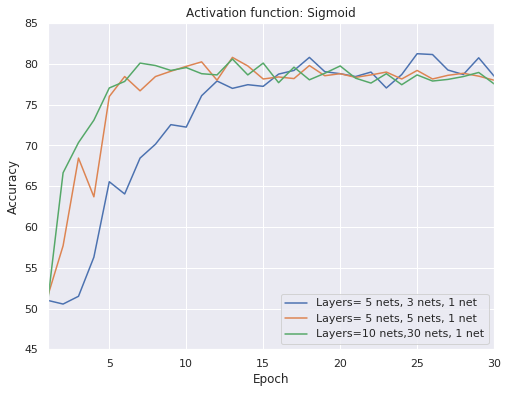

In [52]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure( figsize=(8, 6) )

epoch = list(range(1,31))
plt.plot(epoch,acc1,label='Layers= 5 nets, 3 nets, 1 net')
plt.plot(epoch,acc2,label='Layers= 5 nets, 5 nets, 1 net')
plt.plot(epoch,acc3,label='Layers=10 nets,30 nets, 1 net')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([1,30])
plt.ylim([45,85])
plt.title('Activation function: Sigmoid')
plt.legend(loc='lower right')
plt.show()

### Test 2

In [53]:
# Parameters
learning_rate =  0.01
reg_lambda    =     0

# Define layers
w1 = list(); w2 = list(); w3 = list()

addLayer(w1,n_features+1,5)
addLayer(w1,5,3); addLayer(w1,3,1)

addLayer(w2,n_features+1,5)
addLayer(w2,5,5); addLayer(w2,5,1)

# Train MLP
acc1 = trainMLP(w1,learning_rate,reg_lambda,tanh,sigmoid)
acc2 = trainMLP(w2,learning_rate,reg_lambda,tanh,sigmoid)


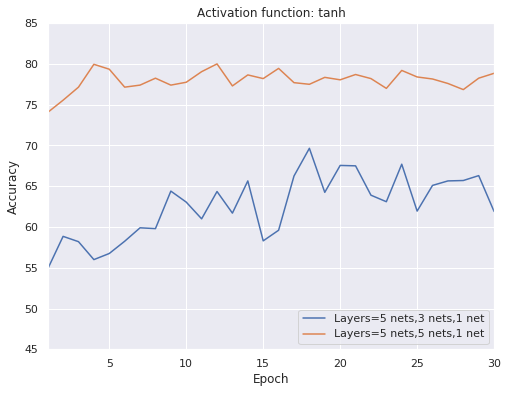

In [56]:
figure( figsize=(8, 6) )
plt.plot(epoch,acc1,label='Layers=5 nets,3 nets,1 net')
plt.plot(epoch,acc2,label='Layers=5 nets,5 nets,1 net')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim([1,30])
plt.ylim([45,85])
plt.title('Activation function: tanh')
plt.legend(loc='lower right')
plt.show()